# Counterfactual prediction

## Imports

In [1]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import minmax_scale
from scipy import sparse
import os
import DeepDive
import torch
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import r2_score

In [2]:
import sys
sys.path.insert(0, "../utils")
from utils import get_colormap_colors, preprocess, set_dropout
from simulation import simulate_scATAC_seq_data, get_DE, get_model_DE, compare_groups

## Counterfactual predicition in simulated data

In [ ]:
n_decoders = 5
model_params = {
    'n_epochs_pretrain_ae' : 200*n_decoders,
    'n_decoders' : n_decoders,
}
train_params = {
    'max_epoch' : 300*n_decoders, 
    'batch_size' : 512, 
}
discrete_covriate_keys = ['Uppercase', 'Lowercase']


In [ ]:
steps = np.arange(0.0, 1.05, 0.1)

In [ ]:
entanglement = []
runs = []
r2s_counter = []
r2s_uncounter = []


n_runs = 3
for run in range(n_runs):
    for idx, i in enumerate(steps):
        dependency_matrix = generate_dependency_matrix(2,2,i)

        simulation_result = simulate_scATAC_seq_data(
            n_cells, 
            n_features, 
            covariates=covariates,
            max_effect_sizes=[0.7, 0.7],
            sample_feature_p=[0.10, 0.10],
            dependency=dependency_matrix
        )

        # Access the fragment count matrix and covariate assignments
        fragment_counts = simulation_result["data"]
        covariate_assignments = simulation_result["covariate_assignments"]
        pivot = simulation_result["pivot"]
        effect_sizes = simulation_result["effect_sizes"]

        adata = anndata.AnnData(fragment_counts)
        adata.X = sparse.csr_matrix(adata.X) 
        adata.obs = covariate_assignments
        adata.obs[discrete_covriate_keys] = adata.obs[discrete_covriate_keys].astype(str)
        adata_to_train = adata[~((adata.obs.Uppercase == 'A') & (adata.obs.Lowercase == 'b'))]
        

        model = DeepDive.DeepDive(adata = adata, 
                            discrete_covariate_names = discrete_covriate_keys,
                            **model_params

                           )
        model.train_model(adata_to_train, None, 
                      **train_params)

        model_path = f'Combinations/DeepDIVE_{run}_{idx}_{i}.pt'
        torch.save(model.state_dict(), model_path)
        model.load_state_dict(torch.load(model_path))

        
        adata_to_eval = adata[((adata.obs.Uppercase == 'A') & (adata.obs.Lowercase == 'b'))].copy()
        adata_to_counter = adata[((adata.obs.Uppercase == 'A') & (adata.obs.Lowercase == 'a'))].copy()
        
        rec_uncounter = model.predict(adata_to_counter, library_size = 10000).copy()
        rec_uncounter = rec_uncounter.to_df()
        
        adata_to_counter.obs['Lowercase'] = 'b'
        rec = model.predict(adata_to_counter, library_size = 10000)
        rec = rec.to_df()
        
        norm = (adata_to_eval.to_df().T / adata_to_eval.to_df().sum(axis = 1)).T * 10000
        
        change = np.log2(effect_sizes['Uppercase']['A'] / effect_sizes['Uppercase']['B']) 
        change = change + np.log2(effect_sizes['Lowercase']['a'] / effect_sizes['Lowercase']['b'])
        change = change != 0
        
        r2_uncounter = round(np.corrcoef(norm.mean()[change], rec_uncounter.mean()[change])[0,1], 2)
        r2 = round(np.corrcoef(norm.mean()[change], rec.mean()[change])[0,1], 2)
        
        runs.append(run)
        entanglement.append(i)
        r2s_counter.append(r2)
        r2s_uncounter.append(r2_uncounter)

In [ ]:
df = pd.DataFrame([runs, entanglement, r2s_counter, r2s_uncounter], index = ['run', 'entanglement', 'Counterfactual', 'Alternative']).T.dropna()

In [ ]:
mean = df.groupby('entanglement').mean()
sd = df.groupby('entanglement').std()

In [ ]:
colors = get_colormap_colors('RdBu', 11)

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (2,2))

X_plot = np.linspace(0.4, 1)
Y_plot = X_plot
sns.lineplot(x=X_plot, y=Y_plot, color = 'k', linestyle='--', linewidth=1, ax = ax, alpha = 0.5)
    
sns.scatterplot(mean, x = 'Alternative', y = 'Counterfactual', c = [colors[int(c*10)] for c in mean.index], s = 25, ax = ax, linewidth = 0.5, edgecolor = 'k')
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")
ax.errorbar(mean.Alternative, mean.Counterfactual, xerr=sd.Alternative, yerr=sd.Counterfactual, fmt="none", color="k")

plt.xlim(0.8, 1)
plt.ylim(0.8, 1)
plt.xlabel('Baseline [R2]')
plt.ylabel('DeepDIVE counterfactual [R2]')


plt.title('Counter-factual prediction')#
plt.savefig('F1H.pdf', transparent=True)

### Counterfactual prediction on real data

In [3]:
n_decoders = 5
model_params = {
    'n_latent' : 32,
    'unknown_encoder_hidden' : [128, 64],
    'unknown_decoder_hidden' : [64, 128],
    'known_decoder_hidden' : [64, 128],
    'n_hidden_adv' : 16,
    'n_epochs_pretrain_ae' : 50*n_decoders,
 
    'device' : 'cuda', 
    'continous_mask_value' : -999, 
    'class_loss' : 'ce', 
    'discrete_covariate_weight' : 1, 
    'continuous_covariate_weight' : 1,
    'n_decoders' : n_decoders,
 
}

train_params = {
    'max_epoch' : 150*n_decoders, 
    'batch_size' : 1024, 
    'shuffle' : True, 
    'num_workers' : 10, 
    'kl_loss_weight':1, 
}

In [4]:
adata = sc.read_h5ad("../data/islet.h5ad")

In [5]:
mapper = {0:'alpha',
1:'beta', 
2:'beta', 
3:'beta', 
4:'alpha', 
5:'beta', 
6:'delta', 
7:'acinar', 
8:'alpha', 
9:'ductal', 
10:'gamma', 
11:'stellate', 
12:'immune', 
13:'endothelial',
}
adata.obs['celltype'] = adata.obs.leiden.map(mapper)

In [6]:
discrete_covriate_keys = ['donor', 'celltype', 'Center', 'Disease', 'Storage', 'Gender', 'Race']
continuous_covriate_keys = ['Age', 'BMI', 'HbA1c', 'Purity', 'map_frac']

In [7]:
adata = preprocess(adata, discrete_covriate_keys, continuous_covriate_keys, frac = 0.1).copy()

In [8]:
donors_to_keep = np.unique(adata.obs.donor, return_counts=True)[0][:5]

In [9]:
adata = adata[adata.obs.donor.isin(list(donors_to_keep)),:].copy()

In [10]:
for donor in donors_to_keep:
    # Split into train and eval
    adata_to_train = adata[(((adata.obs.donor == donor) & (adata.obs.celltype == "beta")) == False),:].copy()
    adata_to_eval = adata[(((adata.obs.donor == donor) & (adata.obs.celltype == "beta")) == True),:].copy()
    
    # Setup the model
    model = DeepDive.DeepDive(adata = adata_to_train, 
                        discrete_covariate_names = discrete_covriate_keys,
                        continuous_covariate_names = continuous_covriate_keys, 
                        **model_params                
                       )
    
    # Train and save models
    model_path = f'../data/Pancreas_loo/Pancreas_LOO_{donor}.pt'
    overwrite = False
    if not os.path.exists(model_path) or overwrite:
        model.train_model(adata, None, **train_params)
        torch.save(model.state_dict(), model_path)

In [11]:
for donor in donors_to_keep:
    # Split into train and eval
    adata_to_train = adata[(((adata.obs.donor == donor) & (adata.obs.celltype == "beta")) == False),:].copy()
    adata_to_eval = adata[(((adata.obs.donor == donor) & (adata.obs.celltype == "beta")) == True),:].copy()
    
    # Setup the model
    model = DeepDive.DeepDive(adata = adata_to_train, 
                        discrete_covariate_names = discrete_covriate_keys,
                        continuous_covariate_names = continuous_covriate_keys, 
                        **model_params                
                       )
    
    # Load model
    model_path = f'../data/Pancreas_loo/Pancreas_LOO_{donor}.pt'
    model.load_state_dict(torch.load(model_path))
    print("Loaded model")
    
    # Set dropout
    set_dropout(model)
    
    # Get ground truth
    sc.pp.normalize_total(adata_to_eval, target_sum = 10000)
    truth = np.array(adata_to_eval.X.mean(axis = 0))[0,:]
    
    # Beta-cells from other donors
    other_donors = list(set(donors_to_keep) - set([donor]))
    for other_donor in other_donors:
        adata_to_eval = adata[(((adata.obs.donor == other_donor) & (adata.obs.celltype == "beta")) == True),:].copy()
        sc.pp.normalize_total(adata_to_eval, target_sum = 10000)
        if other_donor == other_donors[0]:
            others = np.array(adata_to_eval.X.mean(axis = 0))
        else:
            others = np.concatenate((others, np.array(adata_to_eval.X.mean(axis = 0))), axis = 0)
 
    # Baseline
    adata_to_subset = adata[(((adata.obs.donor == donor) & (adata.obs.celltype == "acinar")) == True),:].copy()
    
    # Reconstruct
    recon = model.predict(
        adata_to_subset,
        library_size=10000
    )
    
    # Pseudo-bulk
    baseline = np.array(recon.X.mean(axis = 0))
    
    # Setup up for counter-factual
    adata_to_subset.obs.celltype = "beta"
    
    # Reconstruct
    recon = model.predict(
        adata_to_subset,
        library_size=10000
    )
    
    # Pseudo-bulk
    counterfactual = np.array(recon.X.mean(axis = 0))
    
    # Collect RMSE
    RMSE = [
        np.sqrt(np.mean((counterfactual - truth) ** 2)),
        np.sqrt(np.mean((baseline - truth) ** 2)),
        np.sqrt(np.mean((others.mean(axis = 0) - truth) ** 2))
    ]
    
    # Collect R2
    R2 = [
        r2_score(truth, counterfactual),
        r2_score(truth, baseline),
        r2_score(truth, others.mean(axis = 0))
    ]
    
    # Setup
    res_tmp = pd.DataFrame({
        'Donor': [donor] * 3,
        'RMSE': RMSE,
        'R2': R2,
        'Type': ['Counterfactual', 'Baseline', 'Beta-cells']
    })
        
    # Combine across donors    
    if donor == donors_to_keep[0]:
        res_df = res_tmp
    else:
        res_df = pd.concat((res_df, res_tmp))
        
    
    

Loaded model
Loaded model
Loaded model
Loaded model
Loaded model


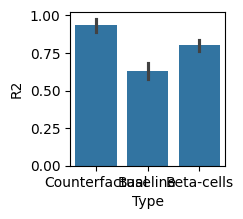

In [12]:
plt.subplots(figsize=(2,2))
sns.barplot(y = 'R2', x = 'Type', data = res_df)
plt.savefig("../figures/S4J.pdf")

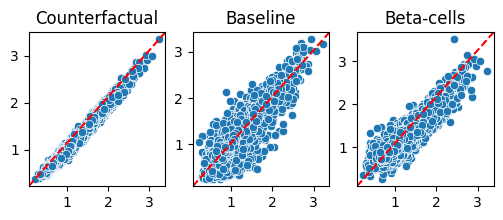

In [13]:
fig, axs = plt.subplots(1,3,figsize=(6,2))
sns.scatterplot(x = truth, y = counterfactual, ax=axs[0])
axs[0].set_title("Counterfactual")
sns.scatterplot(x = truth, y = baseline, ax=axs[1])
axs[1].set_title("Baseline")
sns.scatterplot(x = truth, y = others.mean(axis = 0), ax=axs[2])
axs[2].set_title("Beta-cells")

for ax in axs:
    # Get axis limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Plot diagonal line from bottom-left to top-right
    ax.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], color='red', linestyle='--')

    # Optional: reset limits to ensure they don't auto-adjust
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
plt.savefig("../figures/S4K.pdf")